In [1]:
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [2]:
datMat,classLabels=loadSimpData()

In [3]:
#计算预测值
def stumpClassify(datMat, feat, threshVal, threshIneq):
    retArray=ones((datMat.shape[0],1))
    if threshIneq=='lt':
        retArray[datMat[:,feat]<=threshVal]=-1
    if threshIneq=='gt':
        retArray[datMat[:,feat]>threshVal]=-1
    return retArray

#建立单层决策树
def buildStump(dataArr,classLabels,D):
    dataMat=mat(dataArr);classMat=mat(classLabels).T
    m,n=shape(dataMat)
    numSteps=10.0;bestStump={};bestClasEst=mat(zeros((m,1)))
    minError=inf
    for feat in range(n):
        minfeat=min(dataMat[:,feat]);maxfeat=max(dataMat[:,feat])
        steps=(maxfeat-minfeat)/numSteps
        for i in range(-1,int(numSteps)+1):
            threshVal=minfeat+i*float(steps)
            retArray1=stumpClassify(dataMat, feat, threshVal, 'lt')
            retArray2=stumpClassify(dataMat, feat, threshVal, 'gt')
            error1=mat(zeros((m,1)));error2=mat(zeros((m,1)))
            error1[retArray1!=classMat]=1;error2[retArray2!=classMat]=1
            WeightedError1=D.T*error1;WeightedError2=D.T*error2
            WeightedError=min(WeightedError1,WeightedError2)
            if WeightedError<minError:
                bestStump['feat']=feat
                bestStump['threshVal']=threshVal
                if WeightedError==WeightedError1:
                    bestStump['threshIneq']='lt'
                if WeightedError==WeightedError2:
                    bestStump['threshIneq']='gt'
                minError=WeightedError
    bestClasEst=stumpClassify(dataMat, bestStump['feat'], bestStump['threshVal'], bestStump['threshIneq'])
    return bestStump,bestClasEst,minError

In [4]:
#完整的单决策树Adaboost算法
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    dataArr=mat(dataArr)
    classMat=mat(classLabels).T
    m,n=dataArr.shape
    D=mat(ones((m,1))/m)
    stumpList=[]
    predict=mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,bestClasEst,minError=buildStump(dataArr,classLabels,D)
        alpha=0.5*log((1.0-minError)/max(minError,1e-16))
        alpha=alpha[0,0]
        bestStump['alpha']=alpha
        stumpList.append(bestStump)
        predict+=alpha*bestClasEst
        aggError=multiply(sign(predict)!=classMat,ones((m,1)))
        
#         print 'iter:%d totalError:%s'%(i,aggError)
        if sum(aggError)==0.0:
            break
        deltaD=mat(zeros((m,1)))
        deltaD[bestClasEst==classMat]=exp(-alpha)/sum(D)
        deltaD[bestClasEst!=classMat]=exp(alpha)/sum(D)
        D=multiply(D,deltaD)
    return stumpList  

In [5]:
def adaClassify(datToClass,stumpList):
    dataMat=mat(datToClass)
    m,n=dataMat.shape
    predict=mat(zeros((m,1)))
    for i in range(len(stumpList)):
        bestClasEst=stumpClassify(dataMat, stumpList[i]['feat'], stumpList[i]['threshVal'], stumpList[i]['threshIneq'])
#         print 'stump:%d prediction:%s'%(i,str(bestClasEst))
        predict+=stumpList[i]['alpha']*bestClasEst
    return sign(predict)

In [6]:
stumpList=adaBoostTrainDS(datMat,classLabels,numIt=40)
print stumpList
print adaClassify(datMat,stumpList)

[{'alpha': 0.69314718055994529, 'feat': 0, 'threshVal': matrix([[ 1.3]]), 'threshIneq': 'lt'}, {'alpha': 1.0986122886681098, 'feat': 1, 'threshVal': matrix([[ 1.]]), 'threshIneq': 'lt'}, {'alpha': 1.1989476363991851, 'feat': 0, 'threshVal': matrix([[ 0.9]]), 'threshIneq': 'lt'}]
[[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [137]:
#自适应加载数据
def loadDataSet(filename):
    #创建数据集矩阵，标签向量
    dataMat=[];labelMat=[]
    #获取特征数目(包括最后一类标签)
    #readline():读取文件的一行
    #readlines:读取整个文件所有行
    numFeat=len(open(filename).readline().split('\t'))
    #打开文件
    fr=open(filename)
    #遍历文本每一行
    for line in fr.readlines():
        lineArr=[]
        curLine=line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        #数据矩阵
        dataMat.append(lineArr)
        #标签向量
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [143]:
dataMat1,labelMat1=loadDataSet('horseColicTraining2.txt')
dataMat2,labelMat2=loadDataSet('horseColicTest2.txt')
stumpList=adaBoostTrainDS(dataMat1,labelMat1,numIt=40)
prediction=adaClassify(dataMat2,stumpList)
error=0
for i in range(len(labelMat2)):
    if prediction[i]!=labelMat2[i]:
        error+=1
print 'ErrorRate:%s'%str(float(error)/len(labelMat2))

ErrorRate:0.208955223881


In [225]:
#绘制ROC曲线
import matplotlib.pyplot as plt
def plotROC(prediction,classLabels):
    ysum=0
    cur=[1.0,1.0]
    curNext=[0,0]
    posNum=sum(array(classLabels)==1.0)
    negMum=float(len(classLabels))-posNum
    xstep=1.0/negMum
    ystep=1.0/posNum
    orderIndex=prediction.squeeze().argsort()
    fig=plt.figure()
    fig.clf()
    ax=plt.subplot(111)
    for index in list(orderIndex):
        if classLabels[index]==1.0:
            curNext[0]=cur[0];curNext[1]=cur[1]-ystep
        else:
            curNext[0]=cur[0]-xstep;curNext[1]=cur[1]
            ysum+=cur[1]
        ax.plot([cur[0],curNext[0]],[cur[1],curNext[1]],c='b')
        cur=curNext[:]
    ax.plot([1.0,0.0],[1.0,0.0],'b--')
    ax.axis([0,1,0,1])
    plt.show()
    print 'area:%.5f'%(ysum*xstep)

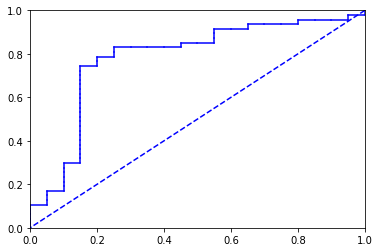

area:0.78085


In [226]:
dataMat1,labelMat1=loadDataSet('horseColicTraining2.txt')
dataMat2,labelMat2=loadDataSet('horseColicTest2.txt')
stumpList=adaBoostTrainDS(dataMat1,labelMat1,numIt=40)
dataMat=mat(dataMat2)
m,n=dataMat.shape
predict=mat(zeros((m,1)))
for i in range(len(stumpList)):
    bestClasEst=stumpClassify(dataMat, stumpList[i]['feat'], stumpList[i]['threshVal'], stumpList[i]['threshIneq'])
#       print 'stump:%d prediction:%s'%(i,str(bestClasEst))
    predict+=stumpList[i]['alpha']*bestClasEst
predict=array(predict)
plotROC(predict,labelMat2)